## Function 3

Drug Discovery Problem
In this example, you are doing drug discovery! You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero. (hint: one of the variables may not cause any effects on the person).

1. Load the provided initial data.
2. Visualize the current data to understand its structure.
3. Fit a Gaussian Process (GP) surrogate model.
4. Use Bayesian optimization to suggest the next best point(s).

08/05/25 - Noticing the overlap of predicted heat map suggesting max is in the 4 range on ingredients 


In [1]:
# update data weekly
import numpy as np
import os

# Function number (update this as needed)
function_id = 3  # change for f2, f3, etc.

# Load original data
inputs_path = f'function_{function_id}/initial_inputs.npy'
outputs_path = f'function_{function_id}/initial_outputs.npy'
inputs = np.load(inputs_path)
outputs = np.load(outputs_path)

# Load new data (replace this with your actual new submissions)
# Example: new 2D point with corresponding output
# week1:0.409031	0.517677	0.402788	and -0.006715206
# week2: 0.35914221	0.31923248	0.46438383	and -0.017215488
# week3_1: 0.504444	0.505995	0.521142 and -0.0229422728627188
# week3_2f: 0.353583	0.463798	0.472660	and -0.009185704
# w4-1t: 0.420288	0.442645	0.434710	-0.004854966
# w4-2f: 0.412158	0.473764	0.443344	-0.016840336
# w5-1t: 0.359232	0.418294	0.379792	and -0.021182533
# w5-2f: 0.510359	0.367228	0.462187	and -0.00570854134032161
# w6-1t: 0.456936	0.396208	0.424800 and -0.00743659196316015
# w6-2f: 0.410288	0.442645	0.424710 and -0.00736223078734777
# w7-1t: 0.418288	0.452645	0.423710 and -0.00543898402779`
# w7-2f: 0.460000	0.452645	0.413710 and -0.0069671301107049
# w8-1t: 0.433512	0.451996	0.410000 and -0.0167396936206294
# w8-2f: 0.410000	0.460000	0.423523 and -0.00500308055152227
# w9-1t: 0.405000	0.462000	0.423523 and -0.0123411775031949
# W9-2f: 0.460000	0.410000	0.460000 and -0.00829774759061829
# w10-1t: 0.460000	0.460000	0.460000 and -0.00663025000015425
# w10-2f: 0.460000	0.460000	0.433000 and -0.00962303920658095

new_inputs = np.array([[0.460000, 0.460000, 0.433000]])
new_outputs = np.array([-0.00962303920658095])

# Concatenate new data to existing
updated_inputs = np.vstack([inputs, new_inputs])
updated_outputs = np.concatenate([outputs, new_outputs])
print("updated_inputs shape:", updated_inputs.shape)
print("updated_outputs shape:", updated_outputs.shape)
# Optionally: save backup copies before overwriting
np.save(f'function_{function_id}/backup_inputs.npy', inputs)
np.save(f'function_{function_id}/backup_outputs.npy', outputs)

# Save updated files
np.save(inputs_path, updated_inputs)
np.save(outputs_path, updated_outputs)

print("Updated data saved.")

updated_inputs shape: (33, 3)
updated_outputs shape: (33,)
Updated data saved.


inputs_f3 shape: (33, 3)
outputs_f3 shape: (33,)


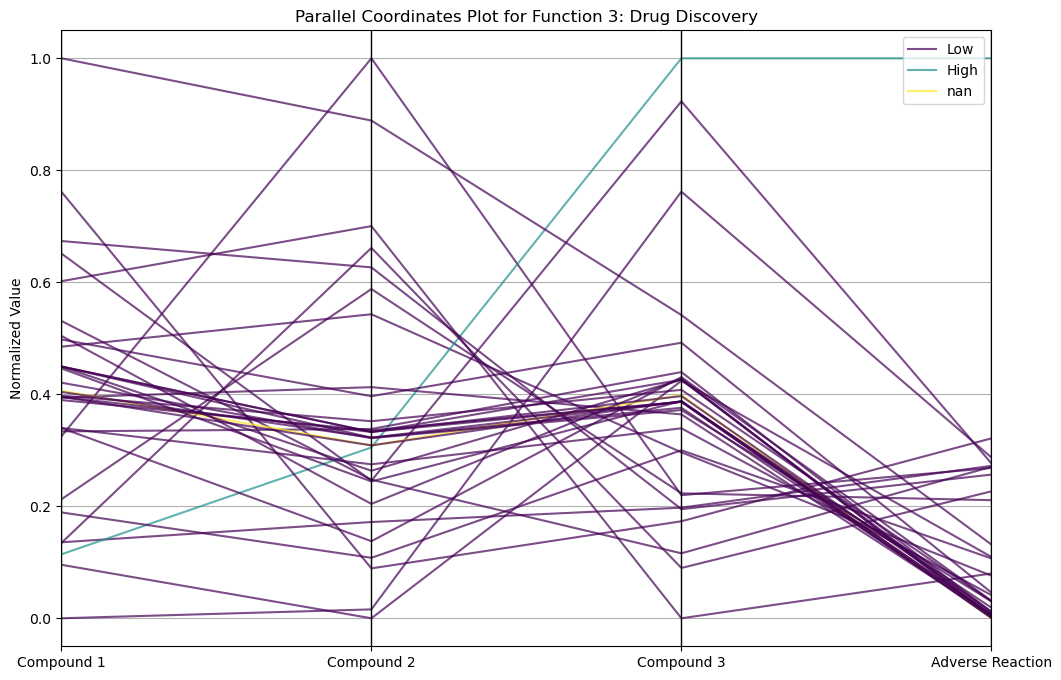

Next best suggested input (Compounds): [0.96599485 0.61443825 0.06608864]
Suggested next best input (6 decimals): ['0.965995', '0.614438', '0.066089']
Predicted adverse reaction: 0.054507940254076584


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler

# Load initial data
inputs_f3 = np.load('function_3/initial_inputs.npy')
outputs_f3 = np.load('function_3/initial_outputs.npy')
print("inputs_f3 shape:", inputs_f3.shape)
print("outputs_f3 shape:", outputs_f3.shape)

# Normalize outputs: make everything positive and aim to minimize distance to 0
num_negative = np.sum(outputs_f3 < 0)
if num_negative > len(outputs_f3) / 2:
    outputs_f3 = -outputs_f3

# Combine inputs and outputs into a DataFrame for visualization
data_f3 = pd.DataFrame(inputs_f3, columns=['Compound 1', 'Compound 2', 'Compound 3'])
data_f3['Adverse Reaction'] = outputs_f3

# Normalize for parallel plot
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_f3), columns=data_f3.columns)

# Bucket output into categories
bins = np.linspace(data_scaled['Adverse Reaction'].min(), data_scaled['Adverse Reaction'].max(), 4)
data_scaled['Reaction Level'] = pd.cut(data_scaled['Adverse Reaction'], bins, labels=['Low', 'Medium', 'High'])

# Plot Parallel Coordinates
plt.figure(figsize=(12, 8))
parallel_coordinates(data_scaled, class_column='Reaction Level', colormap='viridis', alpha=0.7)
plt.title('Parallel Coordinates Plot for Function 3: Drug Discovery')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.show()

# Fit a Gaussian Process surrogate model
gp = GaussianProcessRegressor(kernel=Matern(nu=2.5), n_restarts_optimizer=10, normalize_y=True)
gp.fit(inputs_f3, outputs_f3)

# Define Expected Improvement function for minimization (closer to 0)
def expected_improvement(x, gp, y_best, xi=0.01):
    mean, std = gp.predict(x.reshape(1, -1), return_std=True)
    improvement = y_best - mean
    Z = improvement / std
    ei = improvement * norm.cdf(Z) + std * norm.pdf(Z)
    return -ei  # We minimize EI to find maximum improvement

# Optimization to find next best compound combination
y_best = np.min(np.abs(outputs_f3))  # Closest to zero
bounds = [(np.min(inputs_f3[:, i]), np.max(inputs_f3[:, i])) for i in range(inputs_f3.shape[1])]

result = minimize(expected_improvement,
                  x0=np.mean(inputs_f3, axis=0),
                  args=(gp, y_best),
                  bounds=bounds,
                  method='L-BFGS-B')

next_best_input = result.x
predicted_reaction = gp.predict(next_best_input.reshape(1, -1))[0]

print("Next best suggested input (Compounds):", next_best_input)
print("Suggested next best input (6 decimals):", [f"{x:.6f}" for x in next_best_input])

print("Predicted adverse reaction:", predicted_reaction)


inputs_f3 shape: (29, 3)
outputs_f3 shape: (29,)


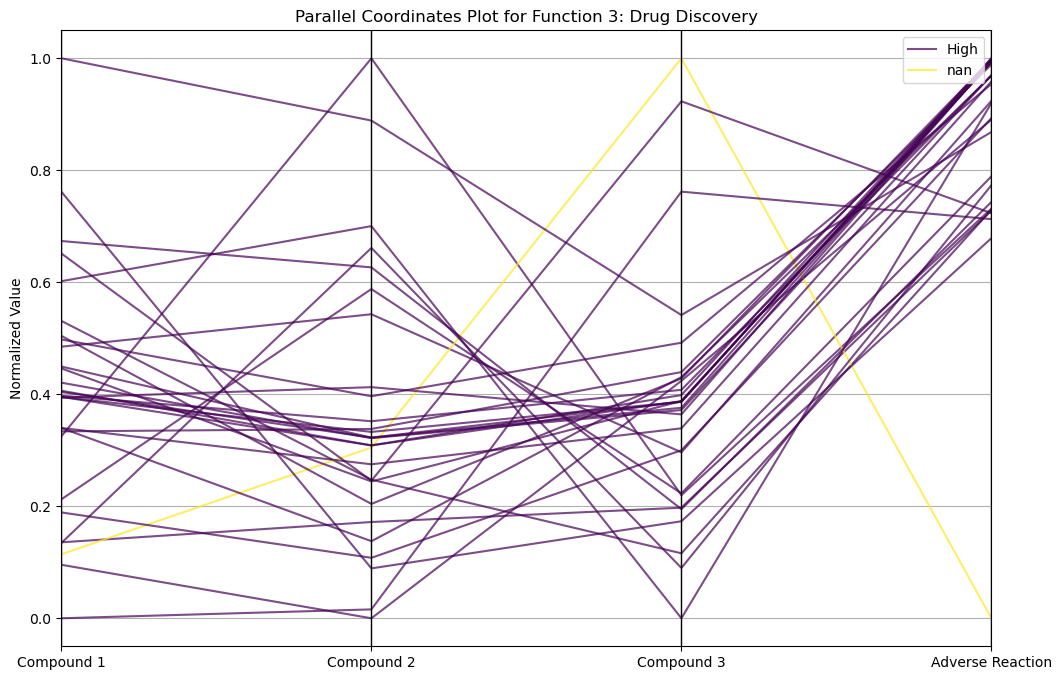

Importance of Compound 1: 0.4747
Importance of Compound 2: 0.2545
Importance of Compound 3: 1.3574


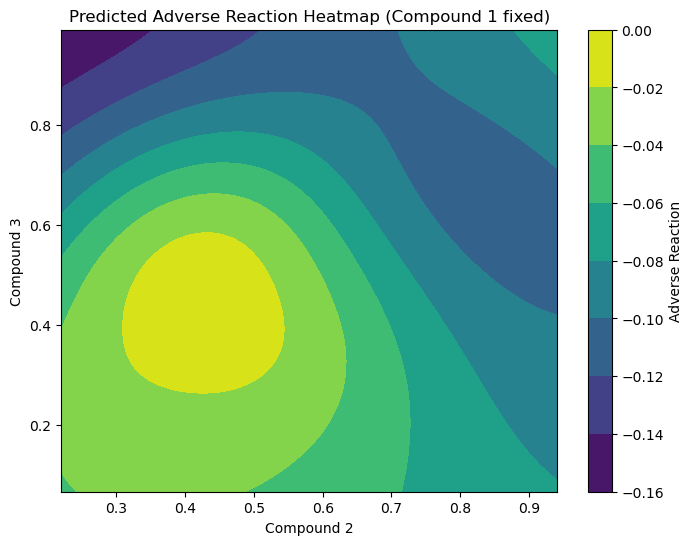

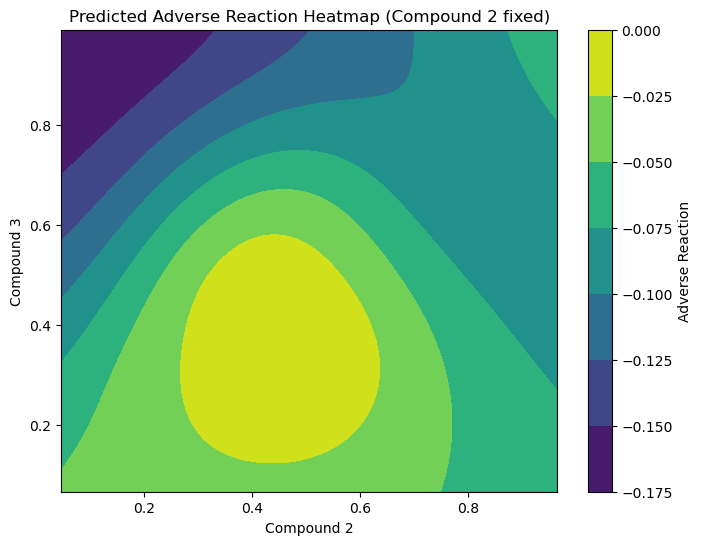

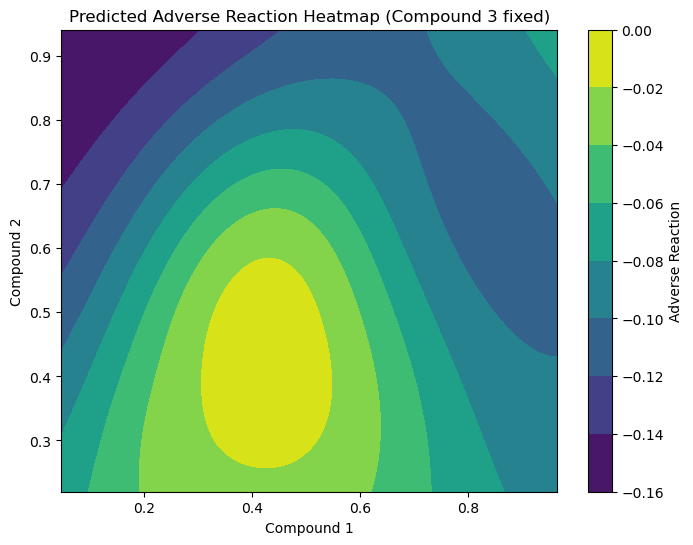

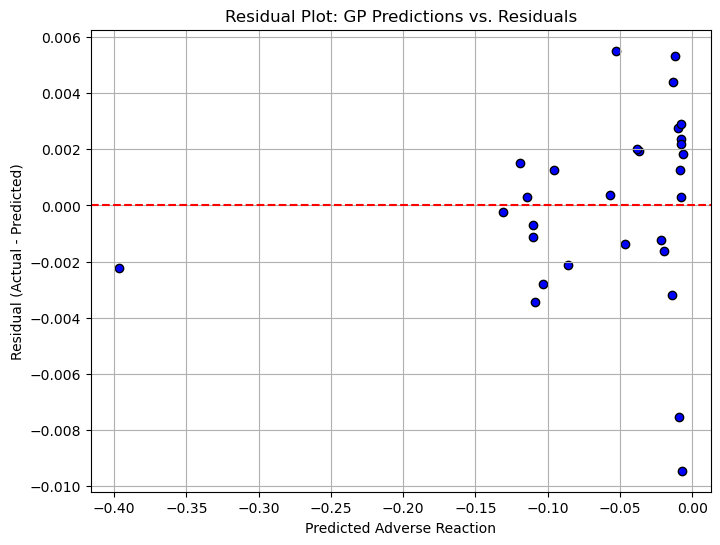

Next best suggested input (Compounds): [0.04680895 0.3219949  0.06608864]
Suggested next best input (6 decimals): ['0.046809', '0.321995', '0.066089']
Predicted adverse reaction: -0.1690110896066598


In [5]:
# used for week2 data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C

# Load initial data
inputs_f3 = np.load('function_3/initial_inputs.npy')
outputs_f3 = np.load('function_3/initial_outputs.npy')
print("inputs_f3 shape:", inputs_f3.shape)
print("outputs_f3 shape:", outputs_f3.shape)

# Normalize outputs: make everything positive and aim to minimize distance to 0
# num_negative = np.sum(outputs_f3 < 0)
# if num_negative > len(outputs_f3) / 2:
#     outputs_f3 = -outputs_f3

# Combine inputs and outputs into a DataFrame for visualization
data_f3 = pd.DataFrame(inputs_f3, columns=['Compound 1', 'Compound 2', 'Compound 3'])
data_f3['Adverse Reaction'] = outputs_f3

# Normalize for parallel plot
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_f3), columns=data_f3.columns)

# Bucket output into categories
bins = np.linspace(data_scaled['Adverse Reaction'].min(), data_scaled['Adverse Reaction'].max(), 4)
data_scaled['Reaction Level'] = pd.cut(data_scaled['Adverse Reaction'], bins, labels=['Low', 'Medium', 'High'])

# Plot Parallel Coordinates
plt.figure(figsize=(12, 8))
parallel_coordinates(data_scaled, class_column='Reaction Level', colormap='viridis', alpha=0.7)
plt.title('Parallel Coordinates Plot for Function 3: Drug Discovery')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.show()

# Fit a Gaussian Process surrogate model
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-6, 1e1), nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, alpha=1e-2)
# gp = GaussianProcessRegressor(kernel=Matern(nu=2.5), n_restarts_optimizer=10, normalize_y=True)
gp.fit(inputs_f3, outputs_f3)

# Feature Importance (Permutation)
perm_importance = permutation_importance(gp, inputs_f3, outputs_f3, n_repeats=30, random_state=42)
for i, col in enumerate(['Compound 1', 'Compound 2', 'Compound 3']):
    print(f"Importance of {col}: {perm_importance.importances_mean[i]:.4f}")

# Heatmap 
from matplotlib import cm
fig = plt.figure(figsize=(8, 6))
x = np.linspace(np.min(inputs_f3[:, 1]), np.max(inputs_f3[:, 1]), 100)
y = np.linspace(np.min(inputs_f3[:, 2]), np.max(inputs_f3[:, 2]), 100)
X, Y = np.meshgrid(x, y)
Z_input = np.zeros((X.size, 3))
Z_input[:, 0] = X.ravel()
Z_input[:, 1] = Y.ravel()
Z_input[:, 2] = np.mean(inputs_f3[:, 0])  # Fix compound 3
Z_pred = gp.predict(Z_input).reshape(X.shape)

plt.contourf(X, Y, Z_pred, cmap=cm.viridis)
plt.title('Predicted Adverse Reaction Heatmap (Compound 1 fixed)')
plt.xlabel('Compound 2')
plt.ylabel('Compound 3')
plt.colorbar(label='Adverse Reaction')
plt.show()

# Heatmap 
from matplotlib import cm
fig = plt.figure(figsize=(8, 6))
x = np.linspace(np.min(inputs_f3[:, 0]), np.max(inputs_f3[:, 0]), 100)
y = np.linspace(np.min(inputs_f3[:, 2]), np.max(inputs_f3[:, 2]), 100)
X, Y = np.meshgrid(x, y)
Z_input = np.zeros((X.size, 3))
Z_input[:, 0] = X.ravel()
Z_input[:, 1] = Y.ravel()
Z_input[:, 2] = np.mean(inputs_f3[:, 1])  # Fix compound 3
Z_pred = gp.predict(Z_input).reshape(X.shape)

plt.contourf(X, Y, Z_pred, cmap=cm.viridis)
plt.title('Predicted Adverse Reaction Heatmap (Compound 2 fixed)')
plt.xlabel('Compound 2')
plt.ylabel('Compound 3')
plt.colorbar(label='Adverse Reaction')
plt.show()


# Heatmap (only if 2D possible)
from matplotlib import cm
fig = plt.figure(figsize=(8, 6))
x = np.linspace(np.min(inputs_f3[:, 0]), np.max(inputs_f3[:, 0]), 100)
y = np.linspace(np.min(inputs_f3[:, 1]), np.max(inputs_f3[:, 1]), 100)
X, Y = np.meshgrid(x, y)
Z_input = np.zeros((X.size, 3))
Z_input[:, 0] = X.ravel()
Z_input[:, 1] = Y.ravel()
Z_input[:, 2] = np.mean(inputs_f3[:, 2])  # Fix compound 3
Z_pred = gp.predict(Z_input).reshape(X.shape)

plt.contourf(X, Y, Z_pred, cmap=cm.viridis)
plt.title('Predicted Adverse Reaction Heatmap (Compound 3 fixed)')
plt.xlabel('Compound 1')
plt.ylabel('Compound 2')
plt.colorbar(label='Adverse Reaction')
plt.show()


# Residual Analysis
predicted_outputs = gp.predict(inputs_f3)
residuals = outputs_f3 - predicted_outputs

plt.figure(figsize=(8, 6))
plt.scatter(predicted_outputs, residuals, c='blue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot: GP Predictions vs. Residuals')
plt.xlabel('Predicted Adverse Reaction')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True)
plt.show()

# Define Expected Improvement function for minimization (closer to 0)
def expected_improvement(x, gp, y_best, xi=0.01):
    mean, std = gp.predict(x.reshape(1, -1), return_std=True)
    improvement = y_best - mean
    Z = improvement / std
    ei = improvement * norm.cdf(Z) + std * norm.pdf(Z)
    return -ei

# Optimization to find next best compound combination
y_best = np.min(np.abs(outputs_f3))
bounds = [(np.min(inputs_f3[:, i]), np.max(inputs_f3[:, i])) for i in range(inputs_f3.shape[1])]

result = minimize(expected_improvement,
                  x0=np.mean(inputs_f3, axis=0),
                  args=(gp, y_best),
                  bounds=bounds,
                  method='L-BFGS-B')

next_best_input = result.x
predicted_reaction = gp.predict(next_best_input.reshape(1, -1))[0]

print("Next best suggested input (Compounds):", next_best_input)
print("Suggested next best input (6 decimals):", [f"{x:.6f}" for x in next_best_input])

print("Predicted adverse reaction:", predicted_reaction)


inputs_f3 shape: (33, 3)
outputs_f3 shape: (33,)


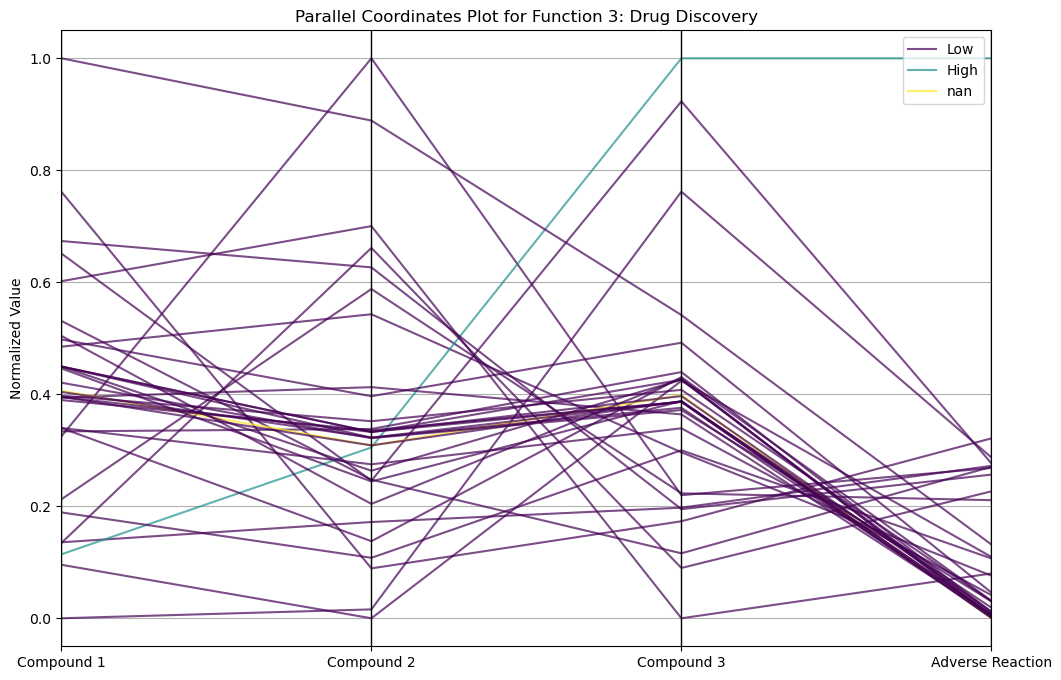

Next best suggested input (Compounds): [0.41 0.41 0.46]
Suggested next best input (6 decimals): ['0.410000', '0.410000', '0.460000']
Predicted adverse reaction: -0.004974034900447427


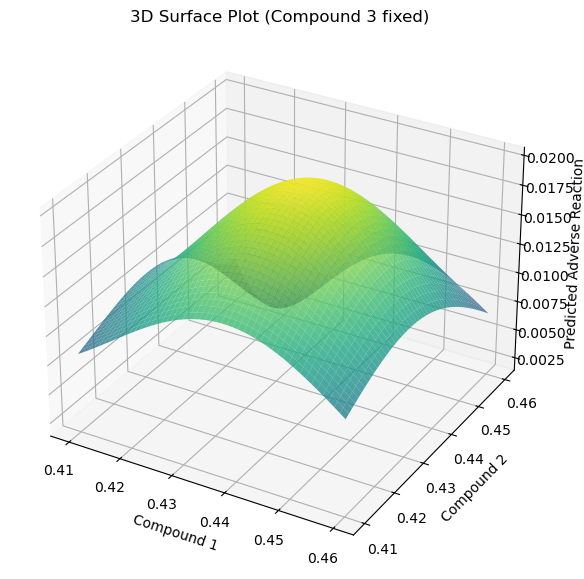

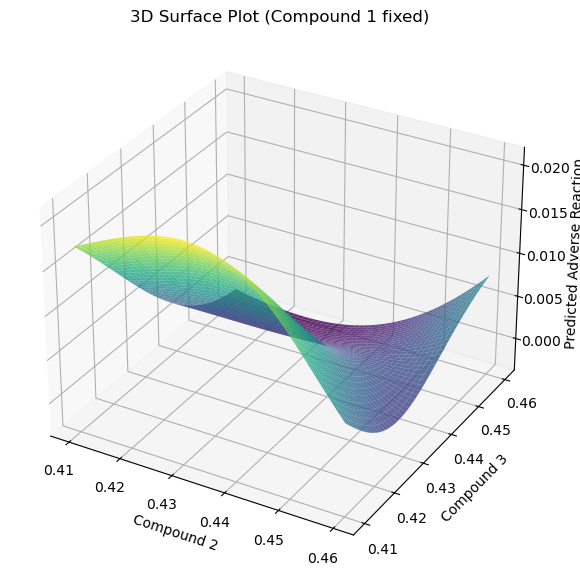

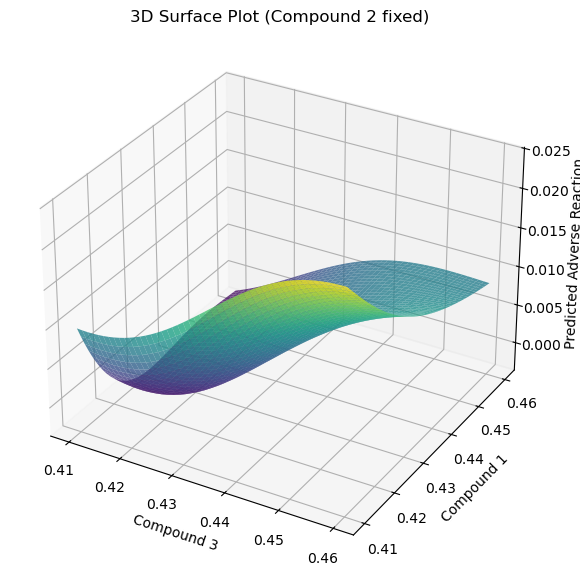

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

# Load initial data
inputs_f3 = np.load('function_3/initial_inputs.npy')
outputs_f3 = np.load('function_3/initial_outputs.npy')

print("inputs_f3 shape:", inputs_f3.shape)
print("outputs_f3 shape:", outputs_f3.shape)

# Invert outputs if needed to make positive
num_negative = np.sum(outputs_f3 < 0)
if num_negative > len(outputs_f3) / 2:
    outputs_f3 = -outputs_f3

# Combine into DataFrame for visualization
data_f3 = pd.DataFrame(inputs_f3, columns=['Compound 1', 'Compound 2', 'Compound 3'])
data_f3['Adverse Reaction'] = outputs_f3

# Normalize for parallel plot
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_f3), columns=data_f3.columns)

bins = np.linspace(data_scaled['Adverse Reaction'].min(), data_scaled['Adverse Reaction'].max(), 4)
data_scaled['Reaction Level'] = pd.cut(data_scaled['Adverse Reaction'], bins, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(12, 8))
parallel_coordinates(data_scaled, class_column='Reaction Level', colormap='viridis', alpha=0.7)
plt.title('Parallel Coordinates Plot for Function 3: Drug Discovery')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.show()

# Fit Gaussian Process
gp = GaussianProcessRegressor(kernel=Matern(nu=2.5), n_restarts_optimizer=10, normalize_y=True)
gp.fit(inputs_f3, outputs_f3)

def expected_improvement(x, gp, y_best, xi=0.01):
    mean, std = gp.predict(x.reshape(1, -1), return_std=True)
    improvement = y_best - mean
    Z = improvement / std
    ei = improvement * norm.cdf(Z) + std * norm.pdf(Z)
    return -ei

y_best = np.min(np.abs(outputs_f3))
bounds = [(0.41, 0.46) for _ in range(inputs_f3.shape[1])]

result = minimize(expected_improvement,
                  x0=np.mean(inputs_f3, axis=0),
                  args=(gp, y_best),
                  bounds=bounds,
                  method='L-BFGS-B')

next_best_input = result.x
predicted_reaction = gp.predict(next_best_input.reshape(1, -1))[0]

print("Next best suggested input (Compounds):", next_best_input)
print("Suggested next best input (6 decimals):", [f"{x:.6f}" for x in next_best_input])
print("Predicted adverse reaction:", predicted_reaction)

# 3D Plot for Compound 1 and 2 (Compound 3 fixed)
x = np.linspace(0.41, 0.46, 50)
y = np.linspace(0.41, 0.46, 50)
X, Y = np.meshgrid(x, y)
Z_input = np.zeros((X.size, 3))
Z_input[:, 0] = X.ravel()
Z_input[:, 1] = Y.ravel()
Z_input[:, 2] = np.mean(inputs_f3[:, 2])
Z_pred = gp.predict(Z_input).reshape(X.shape)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_pred, cmap='viridis', alpha=0.8)
ax.set_xlabel('Compound 1')
ax.set_ylabel('Compound 2')
ax.set_zlabel('Predicted Adverse Reaction')
ax.set_title('3D Surface Plot (Compound 3 fixed)')
plt.show()

# 3D Plot for Compound 2 and 3 (Compound 1 fixed)
X, Y = np.meshgrid(x, y)
Z_input = np.zeros((X.size, 3))
Z_input[:, 0] = np.mean(inputs_f3[:, 0])
Z_input[:, 1] = X.ravel()
Z_input[:, 2] = Y.ravel()
Z_pred = gp.predict(Z_input).reshape(X.shape)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_pred, cmap='viridis', alpha=0.8)
ax.set_xlabel('Compound 2')
ax.set_ylabel('Compound 3')
ax.set_zlabel('Predicted Adverse Reaction')
ax.set_title('3D Surface Plot (Compound 1 fixed)')
plt.show()

# 3D Plot for Compound 3 and 1 (Compound 2 fixed)
X, Y = np.meshgrid(x, y)
Z_input = np.zeros((X.size, 3))
Z_input[:, 0] = Y.ravel()
Z_input[:, 1] = np.mean(inputs_f3[:, 1])
Z_input[:, 2] = X.ravel()
Z_pred = gp.predict(Z_input).reshape(X.shape)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_pred, cmap='viridis', alpha=0.8)
ax.set_xlabel('Compound 3')
ax.set_ylabel('Compound 1')
ax.set_zlabel('Predicted Adverse Reaction')
ax.set_title('3D Surface Plot (Compound 2 fixed)')
plt.show()
